In [ ]:
import pandas as pd
import numpy as np
import json
import gzip
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import re
import string
import nltk
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Video_Games.json.gz

--2020-06-19 20:07:13--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Video_Games.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80222877 (77M) [application/octet-stream]
Saving to: ‘meta_Video_Games.json.gz’

meta_Video_Games.js 100%[===================>]  76.51M  70.7MB/s    in 1.1s    

2020-06-19 20:07:14 (70.7 MB/s) - ‘meta_Video_Games.json.gz’ saved [80222877/80222877]



In [ ]:
data = []
with gzip.open('meta_Video_Games.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [ ]:
df = pd.DataFrame.from_dict(data)

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz

--2020-06-19 20:07:26--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz’

Video_Games_5.json. 100%[===================>] 146.91M  77.6MB/s    in 1.9s    

2020-06-19 20:07:28 (77.6 MB/s) - ‘Video_Games_5.json.gz’ saved [154050105/154050105]



In [ ]:
data2 = []
with gzip.open('Video_Games_5.json.gz') as f:
    for l in f:
        data2.append(json.loads(l.strip()))

# **Data Preprocessing**

In [ ]:
df2 = pd.DataFrame.from_dict(data2)
df2=df2.head(500000)
df2 = df2[["reviewerID","asin","reviewText", "summary" ,"overall"]]
df2.drop_duplicates(keep=False , inplace = True)

In [ ]:
df3 = pd.merge(df, df2, on="asin", how='right')

In [ ]:
df4 = df3.groupby("asin").agg({"overall":"mean", "reviewerID":"count"})
df4["avg_rating"]= df4.overall
df4["Count"]= df4.reviewerID


In [ ]:
df4





,overall,reviewerID,avg_rating,Count
asin,,,,
0700026398,3.125000,8,3.125000,8
0700026657,3.692308,13,3.692308,13
0700099867,3.300000,30,3.300000,30
0804161380,4.816327,49,4.816327,49
3828770193,4.333333,6,4.333333,6
...,...,...,...,...
B01HFRICLE,4.428571,14,4.428571,14
B01HGPUTCA,4.600000,5,4.600000,5
B01HH6JEOC,3.625000,8,3.625000,8


In [ ]:
df5 = pd.merge(df3, df4, on="asin", how='inner')

In [ ]:
df5 = df5[["category","title","asin","reviewerID_x","overall_x","reviewText","summary","avg_rating","Count","brand","feature","description"]]

In [ ]:
df5.head()

,category,title,asin,reviewerID_x,overall_x,reviewText,summary,avg_rating,Count,brand,feature,description
0,"[Video Games, PC, Games]",Anno 2070,0700026657,A1HP7NVNPFMA4N,5.0,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,3.692308,13,Ubisoft,[A new era: while adhering to the fundamentals...,[ANNO 2070BRAND NEW - IN STOCKDVD Rom Software...
1,"[Video Games, PC, Games]",Anno 2070,0700026657,A1JGAP0185YJI6,4.0,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",3.692308,13,Ubisoft,[A new era: while adhering to the fundamentals...,[ANNO 2070BRAND NEW - IN STOCKDVD Rom Software...
2,"[Video Games, PC, Games]",Anno 2070,0700026657,A1YJWEXHQBWK2B,3.0,ok game.,Three Stars,3.692308,13,Ubisoft,[A new era: while adhering to the fundamentals...,[ANNO 2070BRAND NEW - IN STOCKDVD Rom Software...
3,"[Video Games, PC, Games]",Anno 2070,0700026657,A2204E1TH211HT,2.0,"found the game a bit too complicated, not what...",Two Stars,3.692308,13,Ubisoft,[A new era: while adhering to the fundamentals...,[ANNO 2070BRAND NEW - IN STOCKDVD Rom Software...
4,"[Video Games, PC, Games]",Anno 2070,0700026657,A2RF5B5H74JLPE,5.0,"great game, I love it and have played it since...",love this game,3.692308,13,Ubisoft,[A new era: while adhering to the fundamentals...,[ANNO 2070BRAND NEW - IN STOCKDVD Rom Software...


In [ ]:
df7 = df5.groupby("reviewerID_x").agg({"asin":"count"})
df7["user_count"] = df7.asin

In [ ]:
df6 = pd.merge(df5, df7, on="reviewerID_x", how='inner')

In [ ]:
df6.shape

(523317, 14)

In [ ]:
df6.dropna(axis=0,how='all',inplace = True)

In [ ]:
df6= df6.reset_index()
df6.shape

(523317, 15)

In [ ]:
del(df2,df3,df4,df5,df7)

In [ ]:
df6.head()

,index,category,title,asin_x,reviewerID_x,overall_x,reviewText,summary,avg_rating,Count,brand,feature,description,asin_y,user_count
0,0,"[Video Games, PC, Games]",Anno 2070,0700026657,A1HP7NVNPFMA4N,5.0,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,3.692308,13,Ubisoft,[A new era: while adhering to the fundamentals...,[ANNO 2070BRAND NEW - IN STOCKDVD Rom Software...,27,27
1,1,"[Video Games, Retro Gaming & Microconsoles, Ni...",Hexen,B00000JMWB,A1HP7NVNPFMA4N,5.0,This is great for the old school game lovers.,Five Stars,4.111111,18,by\n \n Atari,[hexen],[Like New Condition! Cart Only. FAST & FREE SH...,27,27
2,2,"[Video Games, Retro Gaming & Microconsoles, Ni...",Hexen,B00000JMWB,A1HP7NVNPFMA4N,5.0,This is great for the old school game lovers.,Five Stars,4.111111,18,by\n \n Atari,[hexen],[Like New Condition! Cart Only. FAST & FREE SH...,27,27
3,3,"[Video Games, PC, Accessories, Controllers, Ga...",Logitech Dual Action Game Pad USB,B0000ALFCI,A1HP7NVNPFMA4N,2.0,"This controller stemmed like a good idea, but ...",This controller stemmed like a good idea,3.525000,80,Logitech,[Start playing right away with plug-and-play c...,"[Dual Gamepad,w/ Programmable Joysticks,Black/...",27,27
4,4,"[Video Games, PC, Accessories, Controllers, Ga...",Logitech Dual Action Game Pad USB,B0000ALFCI,A1HP7NVNPFMA4N,2.0,"This controller stemmed like a good idea, but ...",This controller stemmed like a good idea,3.525000,80,Logitech,[Start playing right away with plug-and-play c...,"[Dual Gamepad,w/ Programmable Joysticks,Black/...",27,27


# **EDA**

In [ ]:
dframe = df6[df6.user_count >10].groupby("reviewerID_x").agg({'overall_x':'mean'})

In [ ]:
t = dframe.users.value_counts()/dframe.shape[0]

In [ ]:
t

lenient    0.513806
critic     0.249559
normal     0.236635
Name: users, dtype: float64

In [ ]:
def get_bins(v):
  if v >4.33:
    return "lenient"
  elif v >3.866:
    return 'normal'
  else:
    return "critic"

dframe["users"] = dframe.overall_x.apply(get_bins)


Text(0.5, 0, 'type of user')

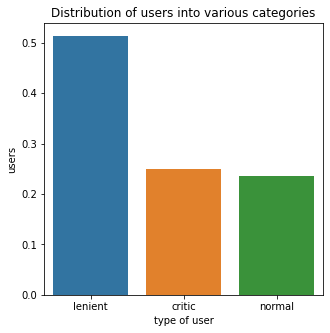

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.barplot(x = t.index , y=t, orient = "v",   )
plt.xticks(rotation =0)
plt.title("Distribution of users into various categories")
plt.xlabel("type of user")

In [ ]:
def get_data(df):
  try:
    df= re.sub('by\n    \n ','',df)
    return df
  except:
    return 0
df6['brand2'] = df.brand.apply(get_data)

In [ ]:
def get_data(df):
  try:
    df= ','.join(df)
    return df
  except:
    return 0
df6['category2'] = df.category.apply(get_data)

In [ ]:
df2 = df6.brand2.value_counts()
df2 = df2.sort_values(ascending = False)

In [ ]:
d={}
def get_tran(df):
  try:
    for i in df:
      if i in d:
        d[i]+=1
      else:
        d[i]=1
  except:
    pass
df = df.category.apply(get_tran)

In [ ]:
del d[1]
ls1 = [ i[0] for i in d[:50]]
ls2 =[ i[1] for i in d[:50]]

In [ ]:
d = sorted(d.items(),key =lambda x : x[1], reverse = True)

Text(0.5, 0, 'Category')

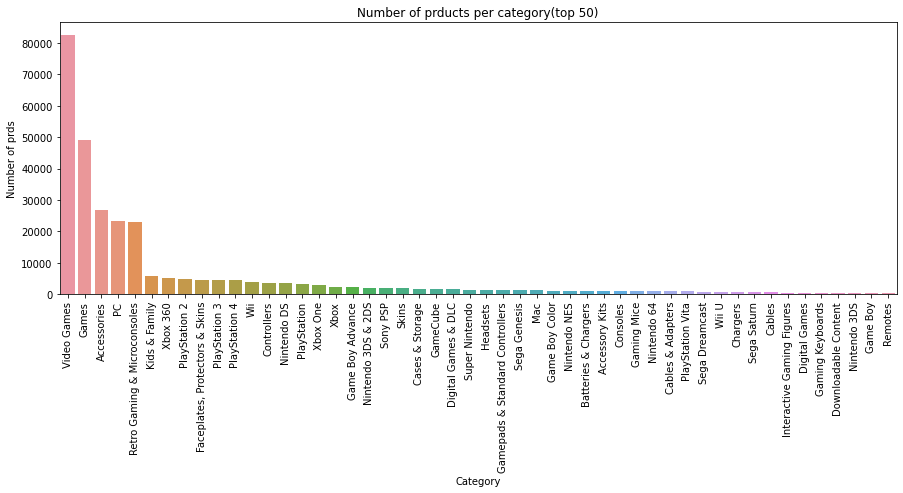

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x = ls1 , y=ls2, orient = "v",  )
plt.xticks(rotation =90)
plt.title("Number of prducts per category(top 50)")
plt.ylabel('Number of prds')
plt.xlabel("Category")

Text(0.5, 0, 'Brand')

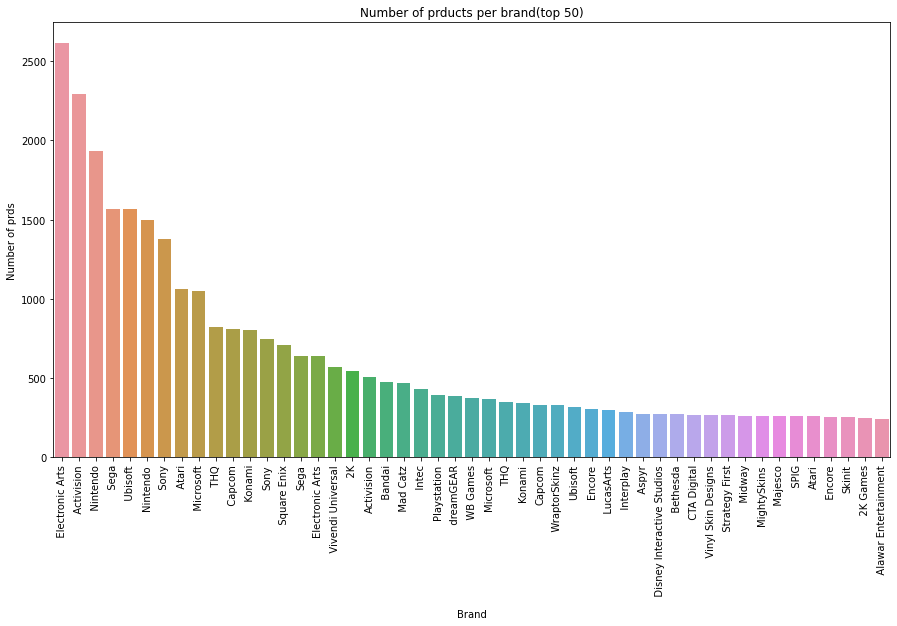

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.barplot(x = df2[1:50].index , y=df2[1:50].values, orient = "v",  )
plt.xticks(rotation =90)
plt.title("Number of prducts per brand(top 50)")
plt.ylabel('Number of prds')
plt.xlabel("Brand")

In [ ]:
df6['info'] = df6.category  + df6.feature 

In [ ]:
def clean(i):
  b = re.sub("\n", "",i)
  b = re.sub(' ', '',b)
  return b
  df6.brand.loc[i]= b.split(' ')

In [ ]:
df_user = df6.drop_duplicates(subset=["asin_x","reviewerID_x","user_count"])
df_user.reset_index(inplace = True)

In [ ]:
df_user.user_count.describe()

count    450055.000000
mean         24.420395
std          68.639648
min           1.000000
25%           6.000000
50%          10.000000
75%          19.000000
max        1054.000000
Name: user_count, dtype: float64

In [ ]:
df_user = df_user[["asin_x","reviewerID_x"]]
df_user.head()


,asin_x,reviewerID_x
0,0700026657,A1HP7NVNPFMA4N
1,B00000JMWB,A1HP7NVNPFMA4N
2,B0000ALFCI,A1HP7NVNPFMA4N
3,B0009VXBAQ,A1HP7NVNPFMA4N
4,B000B8J7K0,A1HP7NVNPFMA4N


In [ ]:
user_list ={}
for i in range(df_user.shape[0]):
  if df_user.reviewerID_x.loc[i] in user_list:
    user_list[df_user.reviewerID_x.loc[i]].append(df_user.asin_x.loc[i])
  else:
    user_list[df_user.reviewerID_x.loc[i]] = [df_user.asin_x.loc[i]]


In [ ]:
df_prd = df6.drop_duplicates(subset=["asin_x","Count"])

In [ ]:
df_prd.Count.describe()

count    17341.000000
mean        30.178017
std         51.755784
min          1.000000
25%          8.000000
50%         14.000000
75%         30.000000
max        806.000000
Name: Count, dtype: float64

In [ ]:
df6.shape

(523317, 16)

In [ ]:
df6.loc[df6['info'].isnull(),'info']=""

In [ ]:
df6["data"] = df6["info"].apply(lambda x: " ".join(x))

In [ ]:
df6.drop_duplicates(subset =["asin_x", "data"], inplace = True)

In [ ]:
df6.shape

(17341, 17)

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# **Modelling**

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def get_data(df):
    word_list = df.split(" ")
    new_wrd_list =  [lemmatizer.lemmatize(i) for i in word_list]
    return ' '.join(new_wrd_list)
df6["clean_data"] = df6["data"].apply(get_data)

In [ ]:
'''reviews = df6["data"] 
countVector = CountVectorizer(max_features = 300, stop_words='english',) 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = pd.DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)'''

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df6['clean_data'])

In [ ]:
df6.reset_index(inplace = True)

In [ ]:
df6.head()

,level_0,index,category,title,asin_x,reviewerID_x,overall_x,reviewText,summary,avg_rating,Count,brand,feature,description,asin_y,user_count,info,data,clean_data
0,0,0,"[Video Games, PC, Games]",Anno 2070,0700026657,A1HP7NVNPFMA4N,5.0,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,3.692308,13,Ubisoft,[A new era: while adhering to the fundamentals...,[ANNO 2070BRAND NEW - IN STOCKDVD Rom Software...,27,27,"[Video Games, PC, Games, A new era: while adhe...",Video Games PC Games A new era: while adhering...,Video Games PC Games A new era: while adhering...
1,1,1,"[Video Games, Retro Gaming & Microconsoles, Ni...",Hexen,B00000JMWB,A1HP7NVNPFMA4N,5.0,This is great for the old school game lovers.,Five Stars,4.111111,18,by\n \n Atari,[hexen],[Like New Condition! Cart Only. FAST & FREE SH...,27,27,"[Video Games, Retro Gaming & Microconsoles, Ni...",Video Games Retro Gaming & Microconsoles Ninte...,Video Games Retro Gaming & Microconsoles Ninte...
2,3,3,"[Video Games, PC, Accessories, Controllers, Ga...",Logitech Dual Action Game Pad USB,B0000ALFCI,A1HP7NVNPFMA4N,2.0,"This controller stemmed like a good idea, but ...",This controller stemmed like a good idea,3.525000,80,Logitech,[Start playing right away with plug-and-play c...,"[Dual Gamepad,w/ Programmable Joysticks,Black/...",27,27,"[Video Games, PC, Accessories, Controllers, Ga...",Video Games PC Accessories Controllers Gamepad...,Video Games PC Accessories Controllers Gamepad...
3,5,5,"[Video Games, Wii]",Wii,B0009VXBAQ,A1HP7NVNPFMA4N,5.0,I love the wii. it's always been one of my fav...,I love the wii,4.483307,629,Nintendo,"[With motion-control technology, the gamer can...",[The Wii console brings a revolution of intera...,27,27,"[Video Games, Wii, With motion-control technol...",Video Games Wii With motion-control technology...,Video Games Wii With motion-control technology...
4,6,6,"[Video Games, Nintendo DS, Games, , Players us...",Mario & Luigi: Partners In Time,B000B8J7K0,A1HP7NVNPFMA4N,3.0,I didn't the game. I was sold a false version ...,whoever is making them is doing a very good jo...,4.333333,48,by\n \n Nintendo,NaN,[Mario and Luigi: Partners In Time an insane s...,27,27,,,


In [ ]:

indices = pd.Series(df6.index, index=df6['asin_x'])

In [ ]:
indices.head()

asin_x
0700026657    0
B00000JMWB    1
B0000ALFCI    2
B0009VXBAQ    3
B000B8J7K0    4
dtype: int64

In [ ]:
indices.index

Index(['0700026657', 'B00000JMWB', 'B0000ALFCI', 'B0009VXBAQ', 'B000B8J7K0',
       'B000FQ9QVI', 'B000P5BSUQ', 'B0018QOWEU', 'B0019R3O7E', 'B0019R4VCQ',
       ...
       'B0153XHRPY', 'B01AWM9Y48', 'B01DW8AGLO', 'B016WRQCKQ', 'B00NUIFZN6',
       'B00XWE53XA', 'B01GYYB5O0', 'B014P7QI6I', 'B00MEXP33U', 'B016K3SI0O'],
      dtype='object', name='asin_x', length=17341)

In [ ]:
#indices.loc['B00000JMWB']

In [ ]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
asin_to_title = dict(zip(df6.asin_x, df6.title))
asin_to_avgscore = dict(zip(df6.asin_x, df6.avg_rating))

In [ ]:
cosine_sim.shape

(17341, 17341)

In [ ]:
cosine_sim

array([[1.        , 0.00387282, 0.00400299, ..., 0.        , 0.00255822,
        0.0125447 ],
       [0.00387282, 1.        , 0.0021496 , ..., 0.        , 0.00512311,
        0.00660784],
       [0.00400299, 0.0021496 , 1.        , ..., 0.        , 0.00650716,
        0.00219275],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00255822, 0.00512311, 0.00650716, ..., 0.        , 1.        ,
        0.00167033],
       [0.0125447 , 0.00660784, 0.00219275, ..., 0.        , 0.00167033,
        1.        ]])

In [ ]:
df = pd.DataFrame(data=cosine_sim, index=indices.index, columns=indices.index)


In [ ]:
df.head()

asin_x,0700026657,B00000JMWB,B0000ALFCI,B0009VXBAQ,B000B8J7K0,B000FQ9QVI,B000P5BSUQ,B0018QOWEU,B0019R3O7E,B0019R4VCQ,B001L1RZ32,B00282WKEW,B002AB7TX8,B002BXKJA0,B002GEKIOG,B003YLWJLA,B004X56PWK,B0053B5RGI,B005EYRAUK,B005EZ5GNW,B006JKASAC,B00737H0KQ,B00AYABWYE,B00CH923NE,B00L4KVO78,B00001N2OM,B00002SUHI,B00002SVBV,B00004DSDE,B00004T77P,B00004U55G,B00004ZB2I,B00005AG1J,B0000899ZX,B00008JOLW,B00009THMU,B0000C0YW2,B0000C0YNT,B0000D12XH,B0000E2XEG,...,B00QDHPVS0,B00PYWLXH8,B00I6A7C7A,B00OXT577K,B00H0GGPNI,B00Q53IWHE,B00YZ4E3YG,B00LMI0LVM,B00DDCBOUC,B01GKH5QZ0,B01A8LQGCQ,B01D0G4DU8,B01H0TGLBU,B015GCU8XK,B013HJ77U6,B00GP2FH1O,B01FWYIYNI,B0155VB214,B00VKPL5LC,B00LWH3HMI,B01BRMDSMQ,B01EYCLJ04,B00SCQF9TG,B013HJ7CII,B00NQT47YM,B00IIYN746,B010OXC93I,B00LVRXS8C,B00XEXQTHI,B00ZAV2KC0,B0153XHRPY,B01AWM9Y48,B01DW8AGLO,B016WRQCKQ,B00NUIFZN6,B00XWE53XA,B01GYYB5O0,B014P7QI6I,B00MEXP33U,B016K3SI0O
asin_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0700026657,1.000000,0.003873,0.004003,0.012212,0.0,0.022866,0.033497,0.001524,0.009081,0.011354,0.011768,0.002842,0.027521,0.008307,0.001162,0.005826,0.006697,0.018209,0.006502,0.001589,0.005756,0.000579,0.012661,0.019270,0.026016,0.0,0.0,0.021119,0.0,0.010346,0.0,0.023158,0.0,0.0,0.012777,0.019470,0.014130,0.036380,0.011723,0.016873,...,0.005378,0.021400,0.000707,0.005015,0.001074,0.007968,0.001677,0.0,0.007828,0.027002,0.007300,0.003805,0.026403,0.007179,0.007659,0.001197,0.005120,0.005222,0.000312,0.005182,0.002126,0.003440,0.001101,0.006944,0.001151,0.000522,0.004378,0.0,0.0,0.0,0.006086,0.012254,0.010862,0.009135,0.0,0.001225,0.005145,0.0,0.002558,0.012545
B00000JMWB,0.003873,1.000000,0.002150,0.020433,0.0,0.006734,0.004491,0.008507,0.008335,0.004220,0.006461,0.004559,0.004737,0.010804,0.012928,0.011822,0.002790,0.009315,0.006115,0.004647,0.006780,0.020158,0.008371,0.014078,0.003071,0.0,0.0,0.009595,0.0,0.006894,0.0,0.001649,0.0,0.0,0.001917,0.003845,0.001866,0.007772,0.002090,0.004893,...,0.003745,0.001596,0.003945,0.007370,0.022420,0.005366,0.005857,0.0,0.001923,0.004264,0.022109,0.016239,0.002806,0.018742,0.006982,0.013322,0.001392,0.002774,0.001583,0.006956,0.007426,0.003162,0.018356,0.006330,0.006428,0.002914,0.001019,0.0,0.0,0.0,0.006131,0.008073,0.002216,0.002000,0.0,0.020239,0.004764,0.0,0.005123,0.006608
B0000ALFCI,0.004003,0.002150,1.000000,0.011213,0.0,0.004630,0.010592,0.001015,0.013293,0.000448,0.011759,0.028062,0.008020,0.007895,0.044551,0.044633,0.007182,0.006477,0.007209,0.006025,0.013584,0.001073,0.007363,0.007771,0.002173,0.0,0.0,0.003799,0.0,0.002730,0.0,0.001205,0.0,0.0,0.008584,0.004097,0.000739,0.004378,0.000827,0.006217,...,0.007610,0.009250,0.001309,0.017970,0.000716,0.005198,0.028474,0.0,0.017748,0.016179,0.014755,0.009593,0.019216,0.001122,0.001297,0.000797,0.012940,0.005202,0.003623,0.001874,0.015000,0.005445,0.000733,0.001176,0.002133,0.000967,0.009765,0.0,0.0,0.0,0.012660,0.002517,0.000977,0.007521,0.0,0.015041,0.012749,0.0,0.006507,0.002193
B0009VXBAQ,0.012212,0.020433,0.011213,1.000000,0.0,0.075469,0.002817,0.143210,0.016227,0.011634,0.026891,0.012569,0.005178,0.007262,0.066695,0.157858,0.006225,0.005247,0.006101,0.003123,0.010375,0.012903,0.005036,0.006561,0.004158,0.0,0.0,0.005140,0.0,0.001115,0.0,0.002951,0.0,0.0,0.000310,0.019227,0.001480,0.008629,0.001657,0.000791,...,0.007186,0.002920,0.000718,0.019412,0.008705,0.005275,0.009221,0.0,0.013976,0.013108,0.018048,0.017647,0.012684,0.001710,0.001978,0.001216,0.012793,0.007468,0.004739,0.001012,0.019721,0.011905,0.029954,0.001793,0.001169,0.015200,0.005759,0.0,0.0,0.0,0.004121,0.008381,0.001490,0.004882,0.0,0.033531,0.006756,0.0,0.003303,0.001202
B000B8J7K0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df.to_csv('Similarity_Matrix_for_Diversity.csv')
!cp Similarity_Matrix_for_Diversity.csv "drive/My Drive/Data (1)"

In [ ]:
def get_rec(prd, df):
  id = indices.loc[prd]
  sim_scores = list(enumerate(cosine_sim[id]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11]
  prd_ids = [i[0] for i in sim_scores]
  rec = [df.asin_x.loc[i] for i in prd_ids]
  rec= sorted(rec, key = lambda x :asin_to_avgscore[x], reverse = True)
  return rec

In [ ]:
import random

In [ ]:
def get_combined_rec(prds):
  freq ={}
  freq2={}
  for item in prds:
    for i in item:
      freq[i]= prds.count(i)
  #randomly arranging the array
  keys = list(freq.keys())
  random.shuffle(keys)
  for key in keys:
    freq2[key]= freq[key]
  freq_final = sorted(freq2, key = lambda x: freq2[x], reverse = True)
  return list(freq_final[:20])

In [ ]:
from tqdm import tqdm


In [ ]:
'A14XH33SGMTA7R' in user_list.keys()

True

In [ ]:
  user= 'A14XH33SGMTA7R'
  rec_list_per_prd=[]
  i=random.choice(user_list[user])
  user_list[user].remove(i)
  for prd in user_list[user][0:]:
    rec_list_per_prd.append(get_rec(prd,df6))
  user_list[user].append(i)
  recommendations= get_combined_rec(rec_list_per_prd)

  print(recommendations)


['B00005LZNI', 'B000W5R8QW', 'B017GY070A', 'B000P5BSUQ', 'B00004SQPD', 'B00B9I9WHY', 'B00551941A', 'B00N23Z8Q8', 'B00002SVBV', 'B00BI9MDSO', 'B001L1RZ32', 'B00I902D7Q', 'B00H2008JO', 'B00690LYJ6', 'B00BI9MDMU', 'B009DZTXR4', 'B0019R3O7E', 'B00004TN9O', 'B001U81442', 'B00002ST2M']


In [ ]:
asin_to_title = dict(zip(df6.asin_x, df6.title))

for asin in recommendations[:10]:
  print(asin_to_title.get(asin))


Klonoa 2: Lunatea's Veil
PlayStation 2 SingStar Bundle - Ceramic White
Samurai Warriors 4 Empires - PlayStation 4
Age Of Mythology:  Titans - PC
PlayStation 2 Console (Slim Line Version 1)
Skylanders Giants GAME ONLY for the PS3
Playstation 2 Console Slim - Ceramic White
Saints Row IV: Re-Elected + Gat out of Hell
Civilization II: Multiplayer (Gold Edition)
AmazonBasics Heavy-Duty Vault Case for PlayStation Vita and Vita Slim (Officially Licensed by Sony)


In [ ]:
#print(user_list[1])

In [ ]:
hit_rate = 0
arhr=0
c=0
for user in tqdm(user_list.keys()):

  if c>1000:
    break

  rec_list_per_prd=[]
  i=random.choice(user_list[user])
  user_list[user].remove(i)
  for prd in user_list[user][0:]:
    rec_list_per_prd.append(get_rec(prd,df6))
  user_list[user].append(i)
  recommendations= get_combined_rec(rec_list_per_prd)
  c+=1
  for r,rec in enumerate(recommendations):
    if i == rec:
      hit_rate=hit_rate+1
      arhr=arhr+1/(r+1)
hit_rate=hit_rate/(c)*100
arhr=arhr/(c)*100
print('Hit Rate:')
print(hit_rate)
print('Average Reciprocal Hit Rate:')
print(arhr)

  2%|▏         | 1000/55179 [03:34<3:33:40,  4.23it/s]

Hit Rate:
1.6983016983016983
Average Reciprocal Hit Rate:
0.3198132846116442


In [ ]:
sim_df=df

In [ ]:
from itertools import combinations 

def Diversity(simsMatrix):
  print("Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations")
  print("           for a given user. Higher means more diverse.")

  n=0
  total=0
  missed=0
  i=0
  for u in user_list.keys():

    if i>1000:  # to set a barrier for number of users
      break
    #the next 5 lines are to just generate the top n recommendations
    rec_list_per_prd=[]
    for prd in user_list[user][0:]:
      rec_list_per_prd.append(get_rec(prd,df6))
    
    recommendations= get_combined_rec(rec_list_per_prd)


    

    i+=1




    
    pairs = combinations(recommendations,2)
    for pair in pairs:

      item1= pair[0]
      item2= pair[1]

      if (item1 and item2 in sim_df.columns):

        similarity= simsMatrix.at[item1, item2]
        total+=similarity
        n+=1
      else:
        missed+=1


  
  S= total/n
  print('Total missed :')
  print(missed)

  return (1-S)


In [ ]:
%%time
print(Diversity(sim_df))

Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations
           for a given user. Higher means more diverse.
Total missed :
0
0.835929352331588
CPU times: user 2min 8s, sys: 21.5 ms, total: 2min 8s
Wall time: 2min 9s


In [ ]:
Rankings=pd.read_csv('/content/drive/My Drive/Data (1)/Popularity_Rankings_for_Diversity.csv')

In [ ]:
def Novelty(Rankings,user_list):

  print("Novelty:   Average popularity rank of recommended items. Higher means more novel.")

  i=0
  n=0
  total=0
  for u in user_list.keys():

    if i>1000:  # to set a barrier for number of users
      break
    #the next 5 lines are to just generate the top n recommendations
    rec_list_per_prd=[]
    for prd in user_list[user][0:]:
      rec_list_per_prd.append(get_rec(prd,df6))
    
    recommendations= get_combined_rec(rec_list_per_prd)

    i+=1
    
    for item in recommendations:
      rank=Rankings.loc[Rankings['asin']==item,'Rank']
      total+=rank.iloc[0]
      n+=1
  #Note: The highest rank of an item is 332 becaue items with equal no. of total ratings have similar ranks 
  return (total/n)


In [ ]:
%%time
print(Novelty(Rankings,user_list))

Novelty:   Average popularity rank of recommended items. Higher means more novel.
317.8213286713287
CPU times: user 2min 37s, sys: 39.5 ms, total: 2min 37s
Wall time: 2min 37s
